In this notebook I study how the KL change with the samples 

In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_logistic as qc
from scipy import stats
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads

[Qibo 0.1.7|INFO|2022-04-11 15:36:33]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-11 15:36:33]: qibotf library was not found. `tf.einsum` will be used to apply gates. In order to install Qibo's high performance custom operators for TensorFlow please use `pip install qibotf`. Alternatively, consider installing the qibojit backend.
[Qibo 0.1.7|INFO|2022-04-11 15:36:33]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.7|WARNING|2022-04-11 15:36:33]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


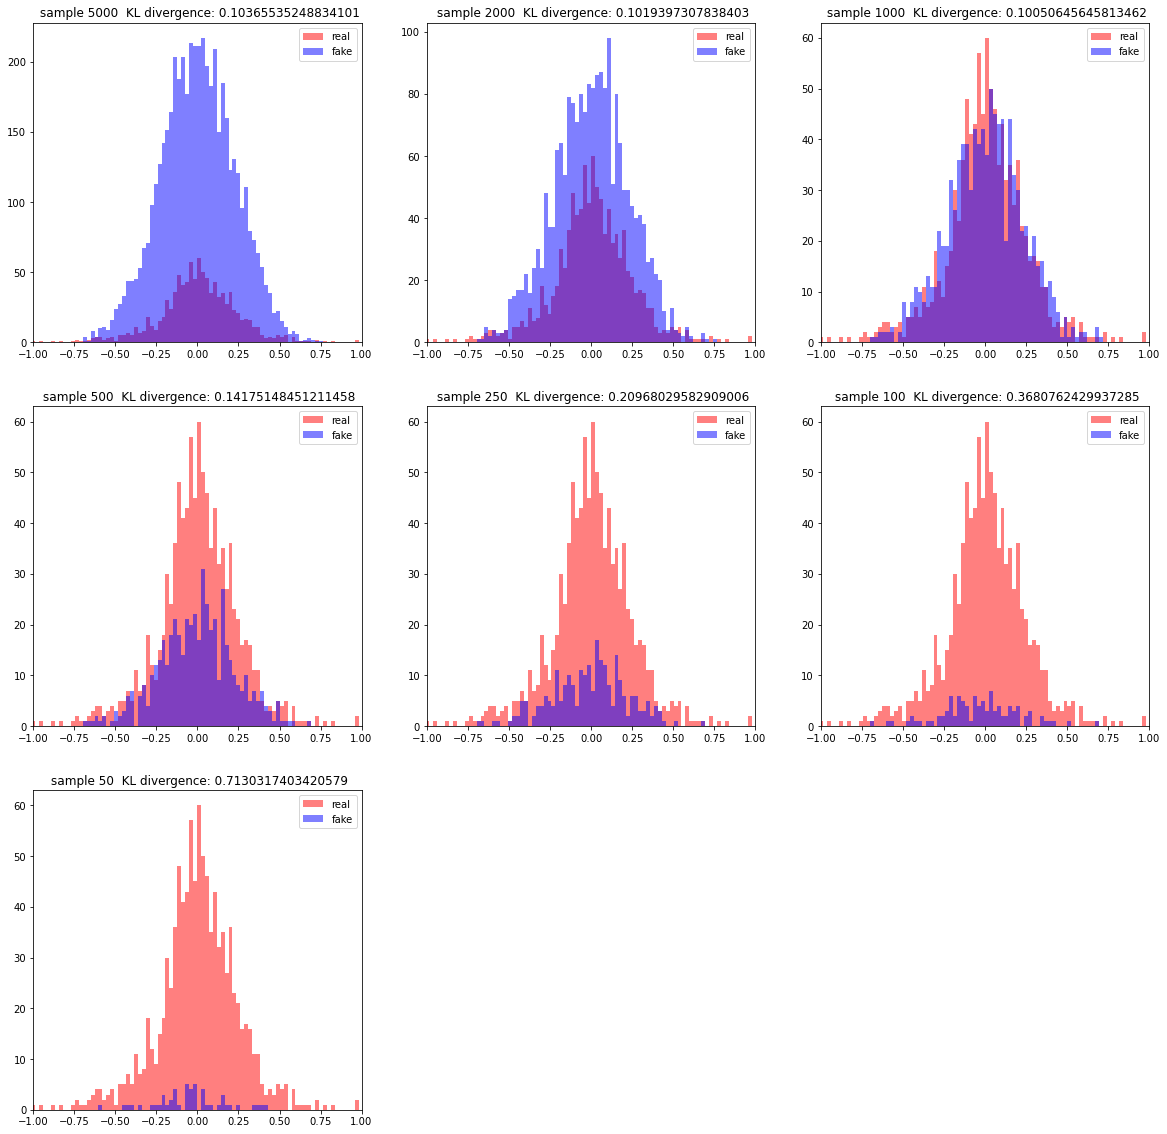

In [23]:
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham

def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems

# number of qubits generator
nqubits = 1
# create hamiltonians
hamiltonian1 = hamiltonian1()

latent_dim=3
n_layers=328
nqubits=1
layers=2
nbins=100
rows=3
cols=3
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))  

samples=[5000, 2000, 1000, 500, 250, 100, 50]


x_real=qc.generate_training_real_samples(1000)
pyplot.figure(figsize=(20,20))

params = np.loadtxt(f"data/PARAMS_1Dgamma_1_3_2_10000_{n_layers}_0.1", delimiter=' ', unpack='true')
params = tf.Variable(params)
   
x_fake,_ = qc.generate_fake_samples(params, latent_dim, 5000, circuit, nqubits, layers, hamiltonian1)

KL_div=[]

image=0
for sample in samples:
   
    #histogram distribution
    
    pyplot.subplot(rows,cols,image+1)
   
    
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy()[:sample], bins=bins_real[1],color='blue', label='fake', alpha=0.5)
    
    pyplot.xlim(-1,1)
    pyplot.title(f" sample {sample}  KL divergence: {kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1) }")
    pyplot.legend()
    KL_div.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
    image+=1

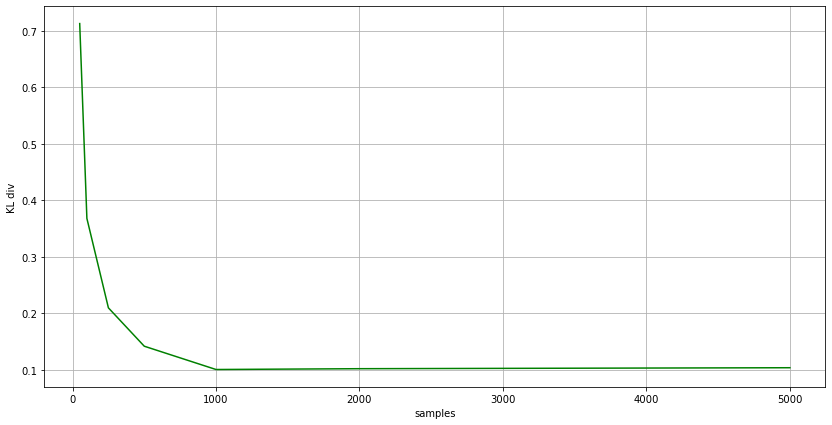

In [24]:
pyplot.figure(figsize=(14,7))
pyplot.plot(samples,KL_div,color="green")
pyplot.xlabel("samples")
pyplot.ylabel("KL div")
pyplot.grid()